In [1]:
import numpy as np 
import pandas as pd 

# data visualisation
import matplotlib.pyplot as plot
import seaborn as sns
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Input and Pre-processing

Using pandas and geopandas to load the eleciton data and map of India geodata. Preprocessing to select only 2019 elections and to modify state names to match.

In [2]:
# read csv containing election data
ge_data = pd.read_csv("/kaggle/input/general-elections-data-1962-2019/All_States_GE.csv")

# we will focus on 2019 general election for this analysis
ge_data = ge_data.loc[ge_data['Year'] == 2019]

# modify state name
ge_data['State_Name'] = ge_data['State_Name'].apply(lambda x : x.replace('_', ' ').replace("&", "and"))

In [3]:
map_shape_file = gpd.read_file('../input/india-shape-file/mw277wc3858.shp')
map_shape_file.replace('NCT of Delhi', 'Delhi', inplace=True)
map_shape_file.set_index('name_1', inplace=True)

def plot_map(merged, column, title):
    fig, ax = plot.subplots(1, figsize=(12, 12))
    ax.axis('off')
    ax.set_title(title,
                fontdict={'fontsize': '15', 'fontweight' : '3'})
    fig = merged.plot(column=column, cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True, missing_kwds={'color':'lightgrey'})

# Battleground states and margin

We can identify which states are polarized, i.e. largely aligned to a single party by looking at the margin by which the elected leader won. We take the average of margin % of the winner over all constituencies.

<Axes: xlabel='Vote_Share_Percentage', ylabel='Margin_Percentage'>

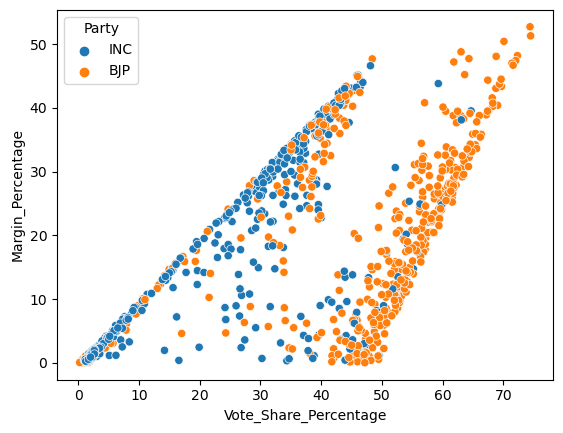

In [4]:
sns.scatterplot(ge_data[ge_data.Party.isin(['INC', 'BJP'])], x='Vote_Share_Percentage', y='Margin_Percentage', hue='Party')


By plotting Vote share vs Margin for the two parties INC and BJP, we can see two major regions - one being majorly INC and one majorly BJP.

The first region is around the line y=x and is probably of close contenders in a constituency. This region has mostly INC members. The second region is 45% or above vote share and is majorly BJP.
This means most candidates that won by a landslide were BJP.

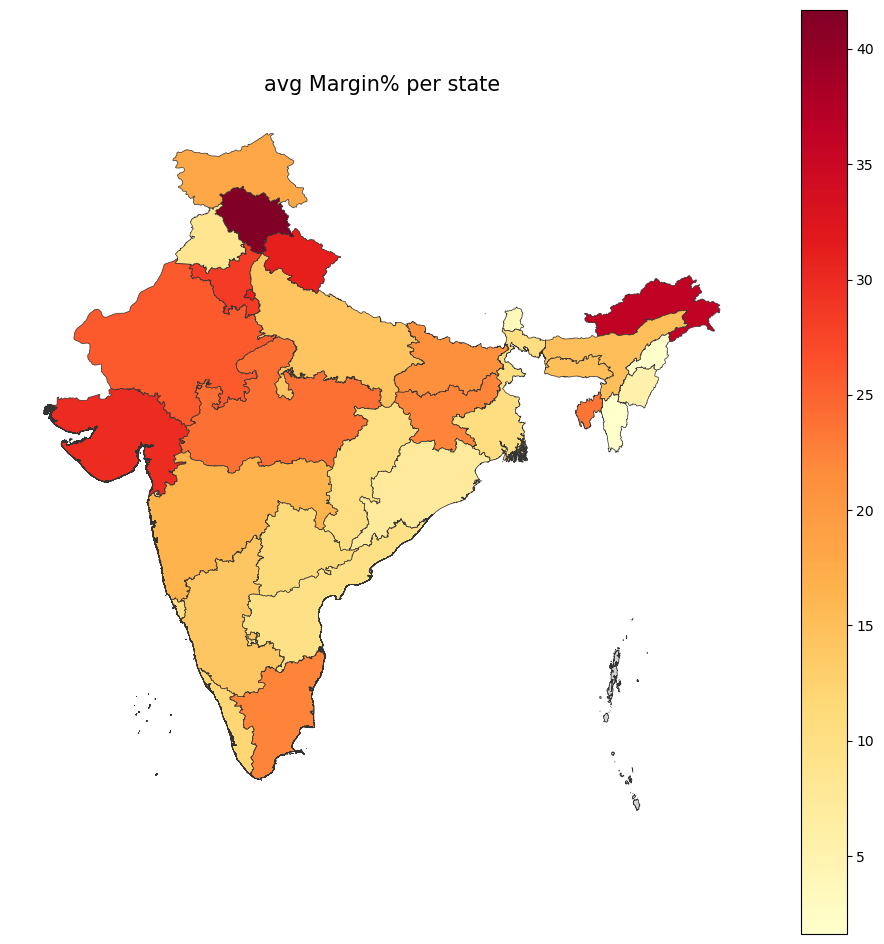

In [5]:
S = ge_data[ge_data.Position == 1].groupby('State_Name').Margin_Percentage.mean()
plot_map(map_shape_file.join(S), 'Margin_Percentage', 'avg Margin% per state')

This plot shows states along with the margin by which the winning candidate won by. The darker the red hue higher the margin. States with light yellow hue are ones where margin of victory was small. These can be considered battleground states.

# Turnout distribution in different constituencies

We can see how voters turn up for GE in different types of constituencies.

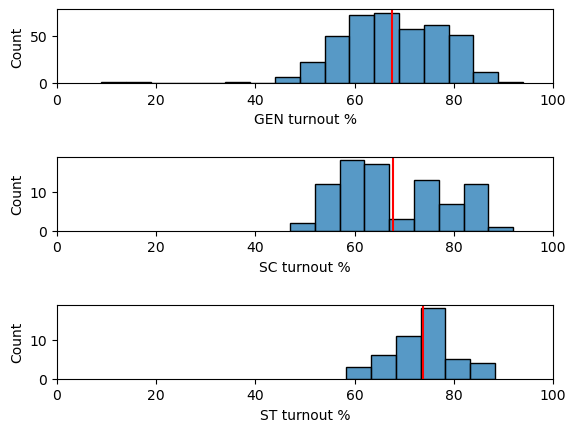

In [6]:
fig, axs = plot.subplots(3)
plot.subplots_adjust(hspace=1)
ge_ = ge_data[ge_data.Position == 1]  # removing duplicates of constituency data
caste_types = ['GEN', 'SC', 'ST']
for i in range(3):
    axs[i].set_xlim(0,100)
    sns.histplot(ge_[ge_.Constituency_Type == caste_types[i]], x="Turnout_Percentage", binwidth=5, ax=axs[i])
    axs[i].set(xlabel=caste_types[i] + " turnout %")
    avg_turnout = ge_[ge_.Constituency_Type == caste_types[i]].Turnout_Percentage.mean()
    axs[i].axvline(avg_turnout, color='r')

As it turns out GEN and SC constituencies turnout seems similar, However the average turnout of ST constituencies is a bit higher. So people belonging to ST communities show up more during elections.

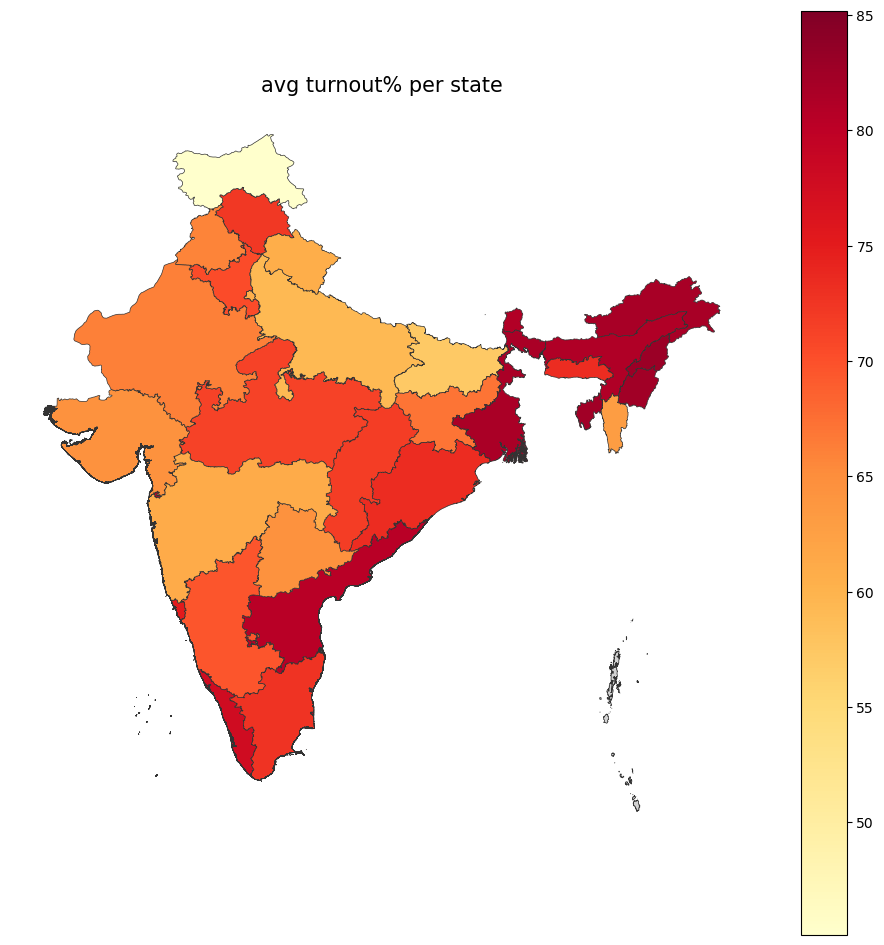

In [7]:
S = ge_.groupby('State_Name').Turnout_Percentage.mean()
plot_map(map_shape_file.join(S), 'Turnout_Percentage', 'avg turnout% per state')

Comparing the turnout state-wise we can see how most of North East has high turnout. NE states also have large ST populations.

Ofcourse there are other factors which produce high voter turnout in states like West Bengal as well.

# Education matters

We can analyse the education profile of the winning candidates.

[Text(0, 0, 'Literate'),
 Text(1, 0, 'Illiterate'),
 Text(2, 0, '5th Pass'),
 Text(3, 0, '8th Pass'),
 Text(4, 0, '10th Pass'),
 Text(5, 0, '12th Pass'),
 Text(6, 0, 'Others'),
 Text(7, 0, 'Graduate'),
 Text(8, 0, 'Post Graduate'),
 Text(9, 0, 'Graduate Professional'),
 Text(10, 0, 'Doctorate')]

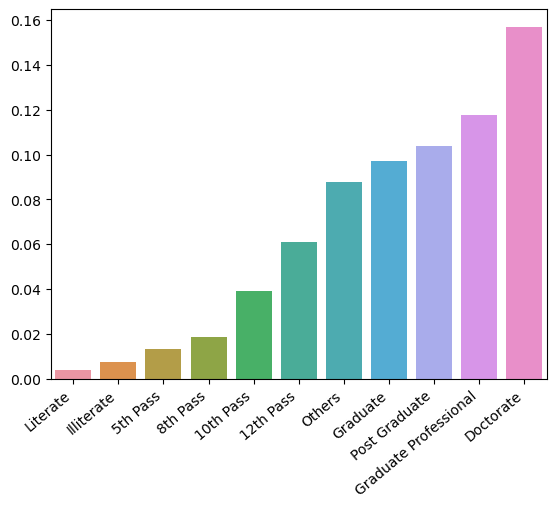

In [8]:
win_percent = ge_data[ge_data.Position == 1].MyNeta_education.value_counts() / ge_data.MyNeta_education.value_counts()
win_percent.sort_values(inplace=True)
p = sns.barplot(x=win_percent.index, y=win_percent.values)
p.set_xticklabels(p.get_xticklabels(), rotation=40, ha="right")

This bar plot shows the probability of a candidate winning given his education level. We can see a direct correlation: higher education leading to higher chances - which is contradictory to beliefs of many (including mine). There is however a slightly higher chance for an illiterate candidate to win compared to a just literate candidate.

# Party inclinations in different types of constituencies

We can analyse the data on the basis of types of parties as well

<Axes: xlabel='Constituency_Type', ylabel='Votes'>

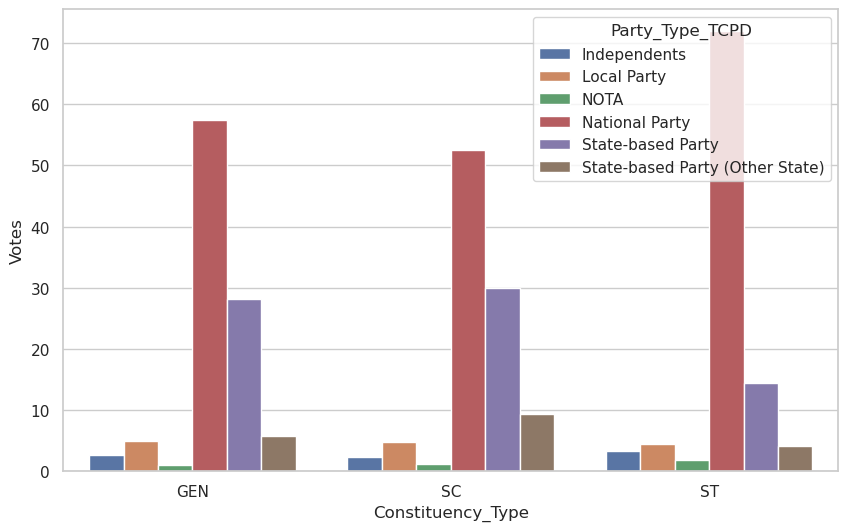

In [9]:
grouped_ge = ge_data.groupby(['Constituency_Type', 'Party_Type_TCPD']).agg({'Votes':sum}).groupby(level=0).apply(lambda x: x / x.sum() * 100).reset_index()
sns.set(style='whitegrid')
plot.figure(figsize=(10, 6))
sns.barplot(x='Constituency_Type', y='Votes', hue='Party_Type_TCPD', data=grouped_ge)

We can also see how the constituencies vote: GEN and SC constituencies vote similarly. However ST constituencies are aligned more towards national parties and less towards state parties. This is possibly because of lack of good state parties in those states.